# Tiny-U-NET for brain tumor segmentation

by: ZaraPhCode

This code is a tiny version of the original U-NET model used for brain tumor segmentation on lgg-brain-tumor MRI data written in colab.

I followed two main proceedures:
### 1- reducing the number of conv layers in U-NET,
### 2- reducind the size of images to 128x128

These two methods reduced the size of the model by a factor of 2.

Here we first download the dataset from kaggle. For this purpose, you should have a kaggle account and recieve an api key (you can search the net to learn how to get your kaggle api key). you will download a <code>.json</code> file which you will upload it later via the following code:

In [ ]:
from google.colab import files
files.upload()

In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


Here we connect to our google drive and specify a folder to download the dataset

In [3]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create a folder in the root directory
!mkdir -p "/content/drive/MyDrive/Kaggle_datasets"

Mounted at /content/drive


time to download the dataset from kaggle:

In [4]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

100% 713M/714M [00:06<00:00, 126MB/s] 
100% 714M/714M [00:06<00:00, 112MB/s]


Here we locate the downloaded file:

In [5]:
!cp -r './lgg-mri-segmentation.zip' /content/drive/MyDrive/Kaggle_datasets/

and then unzip it:

In [6]:
!unzip lgg-mri-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

## 1- Data Investigation

Here we first import necessary libraries and modules.

In [7]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization,Flatten, Dense, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set Parameters to resize
im_width = 128
im_height = 128

* Saving image names and masks in arrays

In [8]:
train_files = []
mask_files = glob('./lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['./lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_2.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_14.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_17.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_16.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_22.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_21.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_23.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_20.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_15.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_10.tif']
['./lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_2_mask.tif', './lgg-mri-segmentation/kaggle_3m/TCGA

* Data visualization

Lets visualize some data to have a better insight. Here the segmented mask is plotted over the original MRI image with lower opacity, so one can see the tumors.

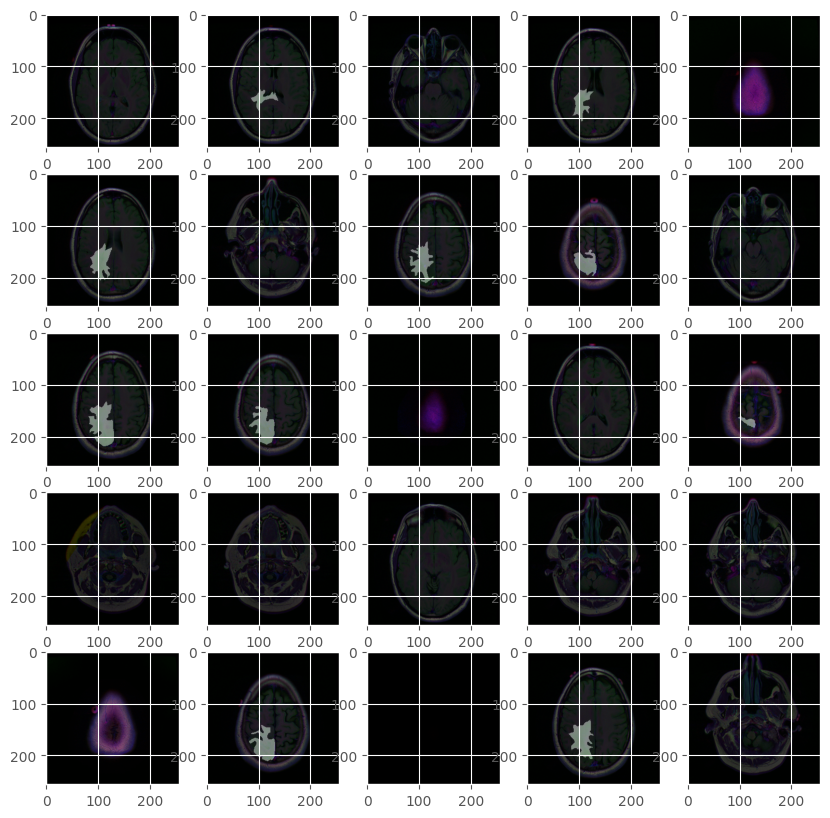

In [ ]:
#Lets plot some samples
rows,cols=5,5
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

* Defining training, validation, and testing sets.

In the following we use the known <code>train_test_split</code> function to split our dataset into train, test, and validation sets:

In [9]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


* Data pre-processing

As the data is huge, we generate them in each batch and give them to the model. Here are the original functions of the U-NET to do that:

In [10]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(im_width,im_height),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

* Metrics related to mask overlay on image

Now, it is time to define specific metrics suitable for this segmentation task. Other typical metrics such as accuracy will not work well for this kind of data. For more information about the metrics, refer to the original U-NET paper.

In [11]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

# Jaccard
def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

# 2-Defining the architecture of the CNN model

Here, I changed the original structure of the U-NET in order to shrink the network size. I have ommitted some convolutional layers but kept residual contacts. This will improve the speed and reduces the network size, while keeping the performance acceptable.

In [12]:
def tiny_unet(input_size=(256,256,3)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [13]:
model = tiny_unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['activation[0][0]']          
 D)                                                                                           

See the model structure:

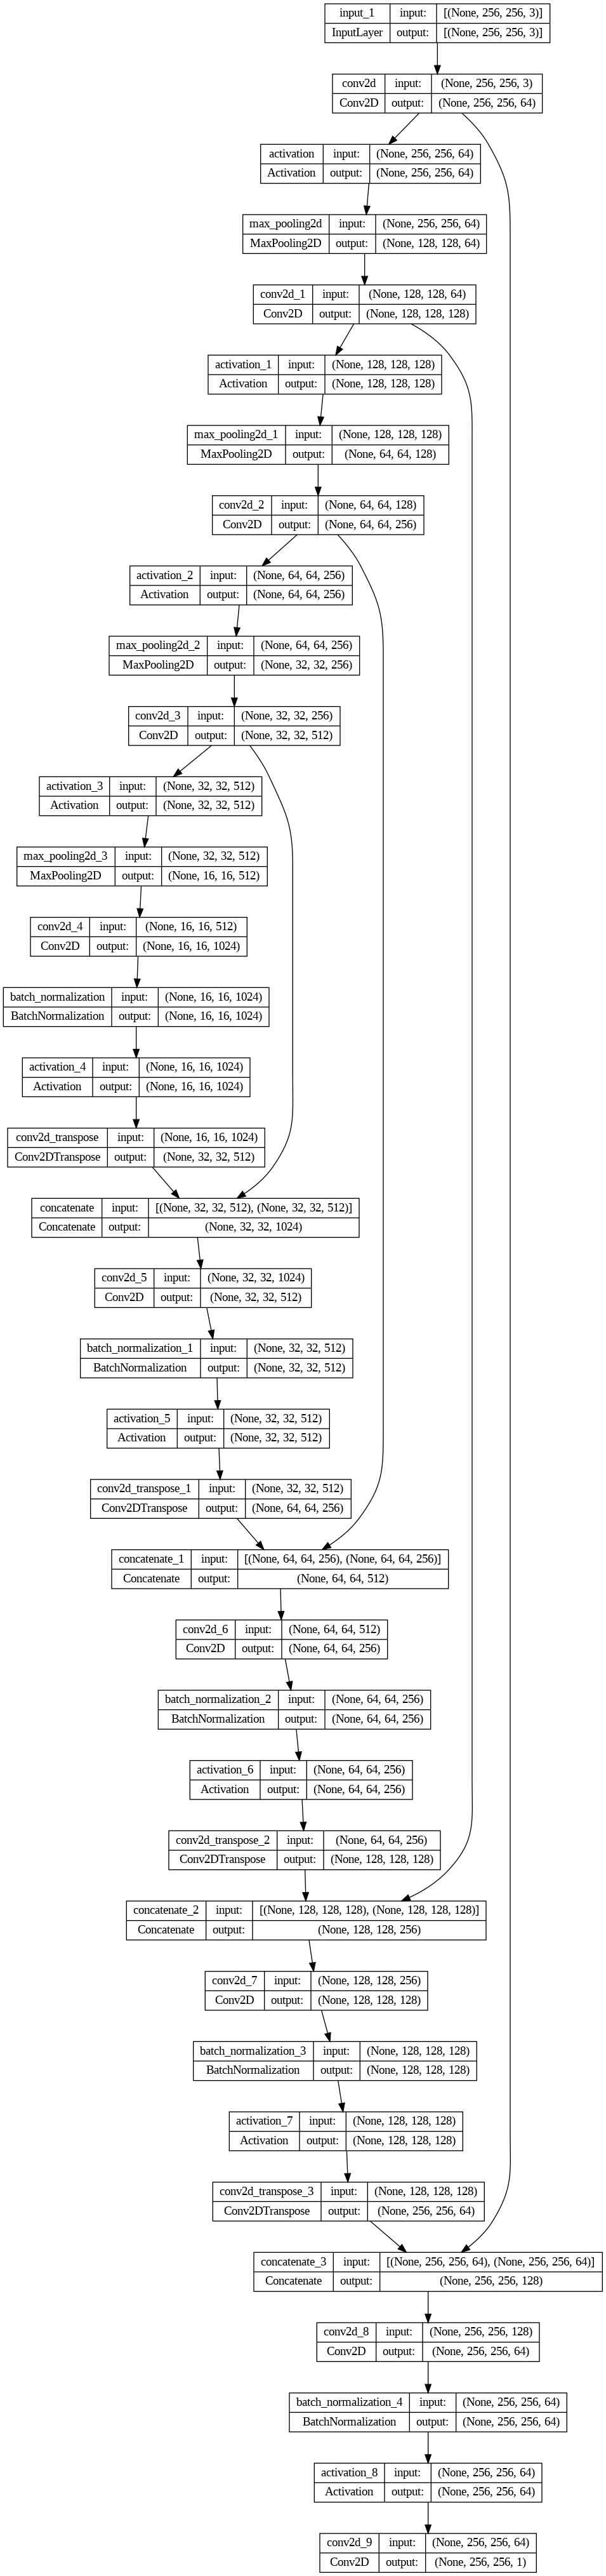

In [14]:
tf.keras.utils.plot_model(model, rankdir="TD", show_shapes=True)

# 3- Training the model

Here I train the model by generating train, test, and validation data.

I put an early stopping for 10 epochs (if there were no considerable progress).

The best result is saved in <code>unet_brain_mri_seg.hdf5</code> file.

I used the defined metrics for compiling the model.

And finally fitting the model.

In [15]:
EPOCHS = 100
BATCH_SIZE = 64

In [16]:
# Defining training image transformations
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

# Creating training set using function train_generator() to separate into batches.
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))

test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

# Defining the model with input_size and 3 channels
model = tiny_unet(input_size=(im_height, im_width, 3))

# Defining the optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Setting callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True), early_stop]

# Compiling the model
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

# Saving history
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/100
45/44 [==============================] - ETA: 0s - loss: -0.1659 - binary_accuracy: 0.9180 - iou: 0.0938 - dice_coef: 0.1667Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02247, saving model to unet_brain_mri_seg.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 71s 856ms/step - loss: -0.1659 - binary_accuracy: 0.9180 - iou: 0.0938 - dice_coef: 0.1667 - val_loss: -0.0225 - val_binary_accuracy: 0.1052 - val_iou: 0.0116 - val_dice_coef: 0.0226
Epoch 2/100
45/44 [==============================] - ETA: 0s - loss: -0.4581 - binary_accuracy: 0.9899 - iou: 0.3039 - dice_coef: 0.4587
Epoch 2: val_loss improved from -0.02247 to -0.17064, saving model to unet_brain_mri_seg.hdf5
44/44 [==============================] - 32s 733ms/step - loss: -0.4581 - binary_accuracy: 0.9899 - iou: 0.3039 - dice_coef: 0.4587 - val_loss: -0.1706 - val_binary_accuracy: 0.9808 - val_iou: 0.1007 - val_dice_coef: 0.1769
Epoch 3/100
45/44 [==============================] - ETA: 0s - loss: -0.5119 - binary_accuracy: 0.9910 - iou: 0.3623 - dice_coef: 0.5158
Epoch 3: val_loss did not improve from -0.17064
44/44 [==============================] - 31s 702ms/step - loss: -0.5119 - binary_accuracy: 0.9910 - iou: 0.3623 - dice_coef: 0.5158 - va

# 4- Validating the model

Here I plotted the evolution of the defined metrics for each epoch for train and validation data:

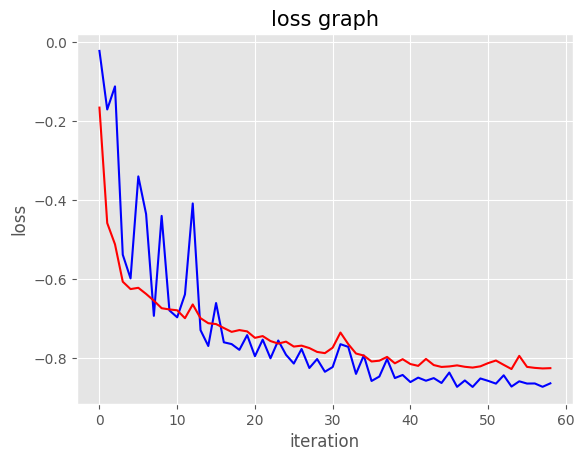

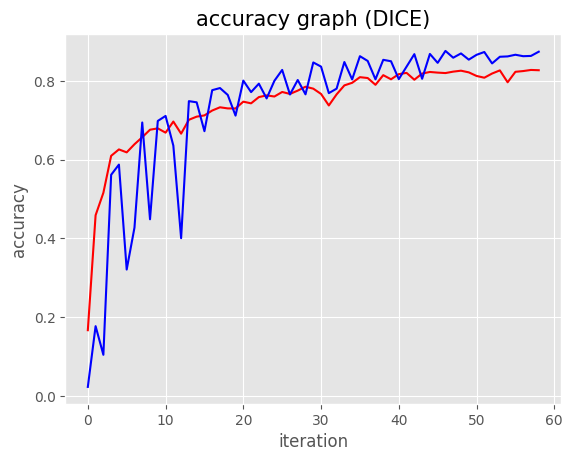

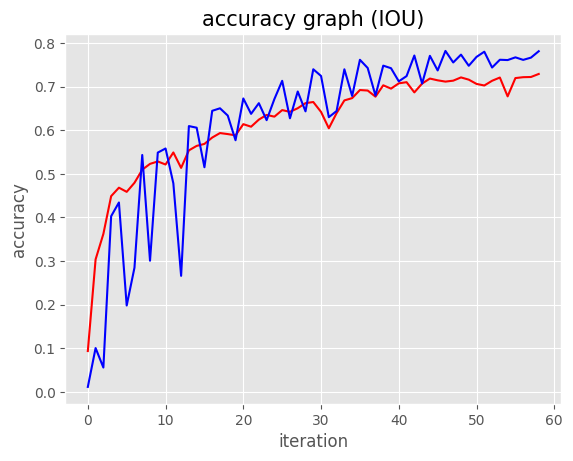

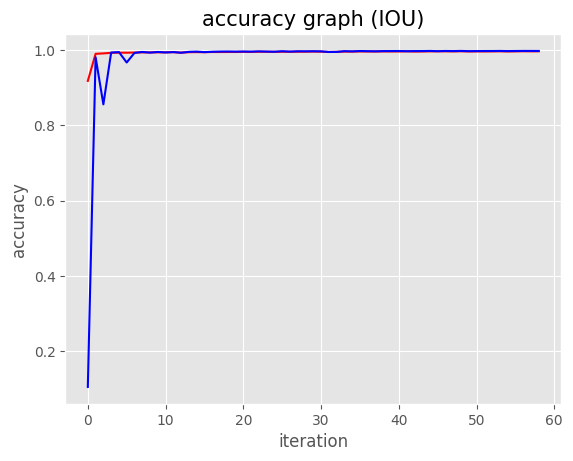

In [17]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']

list_train_bin_acc = a['binary_accuracy']
list_test_bin_acc = a['val_binary_accuracy']

plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph (DICE)', fontsize = 15)
plt.figure(3)
plt.plot(list_trainjaccard, 'r-')
plt.plot(list_testjaccard, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph (IOU)', fontsize = 15)
plt.figure(4)
plt.plot(list_train_bin_acc, 'r-')
plt.plot(list_test_bin_acc, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph (IOU)', fontsize = 15)
plt.show()
# Red = Training
# Blue = Validation

* Using the model in a test set

Now, we can validate the model using the test set:

In [18]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
6/6 [==============================] - 3s 519ms/step - loss: -0.8680 - binary_accuracy: 0.9975 - iou: 0.7764 - dice_coef: 0.8725
Test lost:  -0.8680064082145691
Test IOU:  0.9975483417510986
Test Dice Coefficent:  0.7763605117797852


* Testing on some samples

Here is the plot of the trained model on some of the data in our test dataset.

1/1 [==============================] - 1s 1s/step


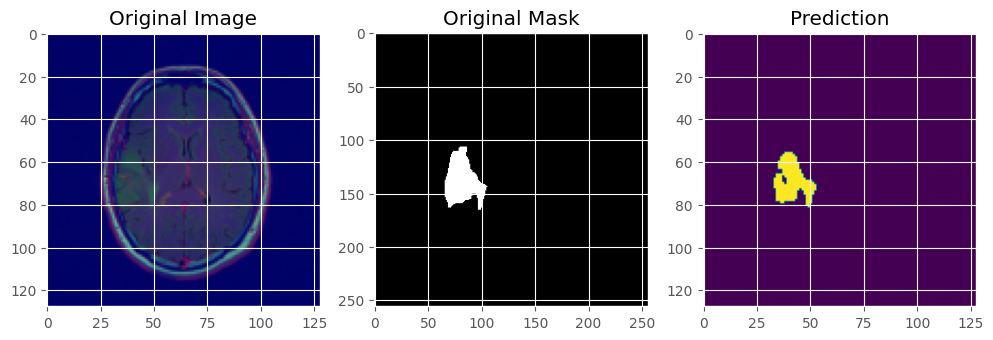

1/1 [==============================] - 0s 36ms/step


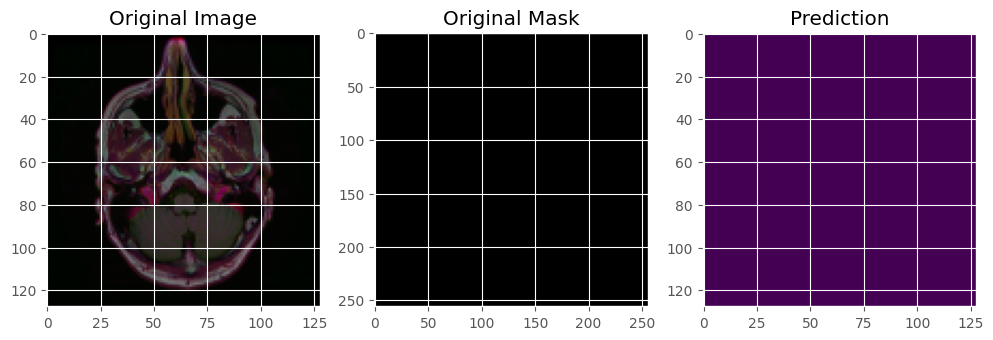

1/1 [==============================] - 0s 27ms/step


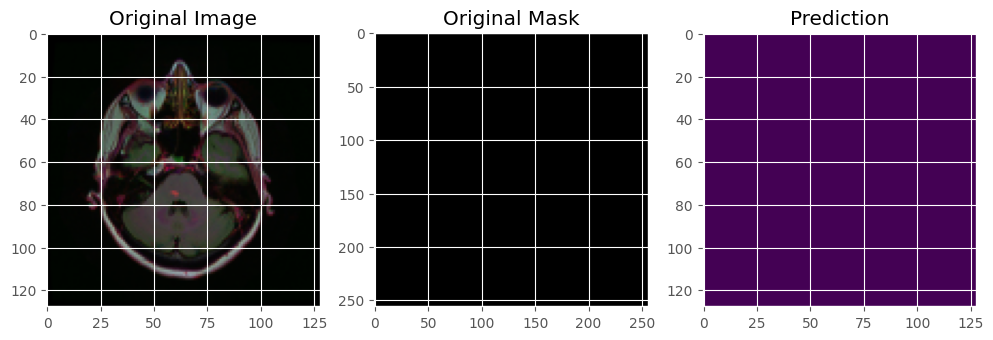

1/1 [==============================] - 0s 27ms/step


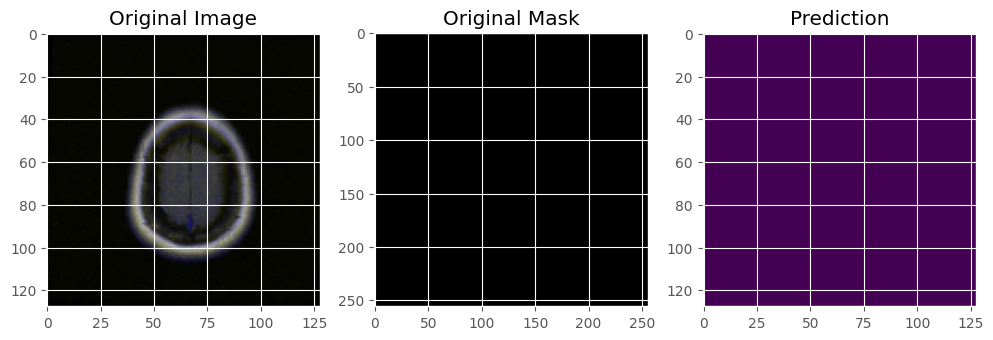

1/1 [==============================] - 0s 20ms/step


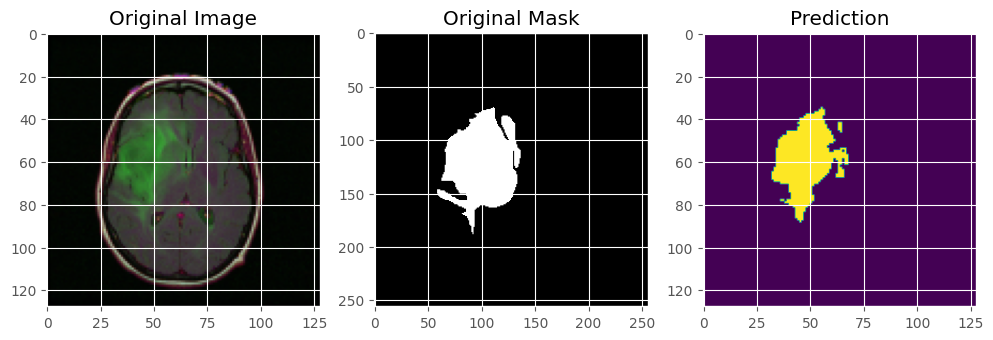

1/1 [==============================] - 0s 21ms/step


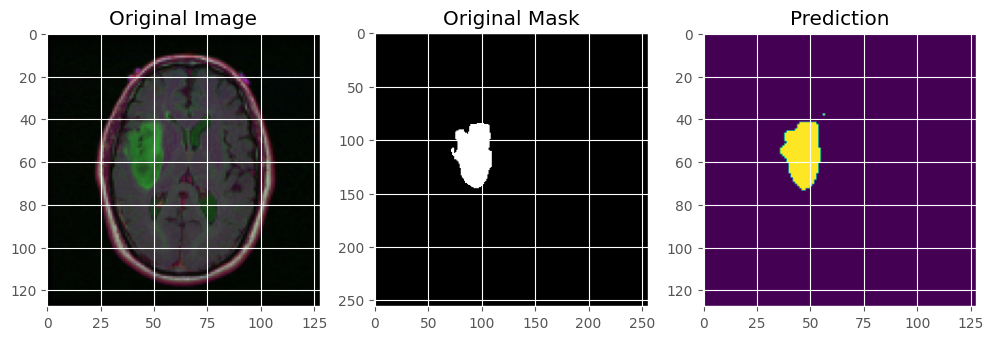

1/1 [==============================] - 0s 19ms/step


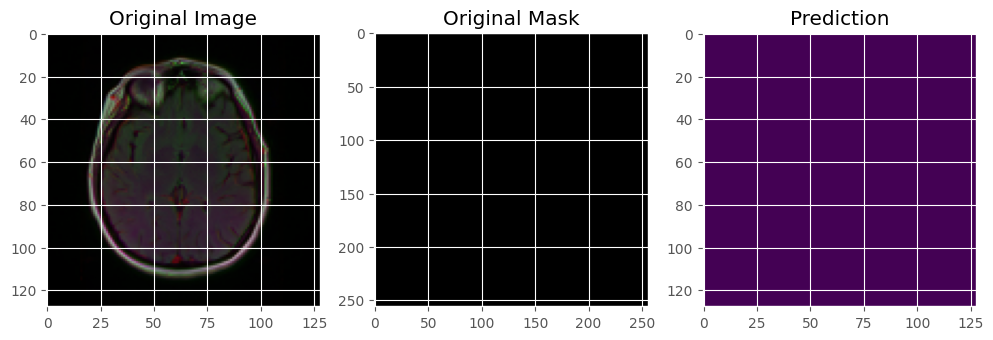

1/1 [==============================] - 0s 26ms/step


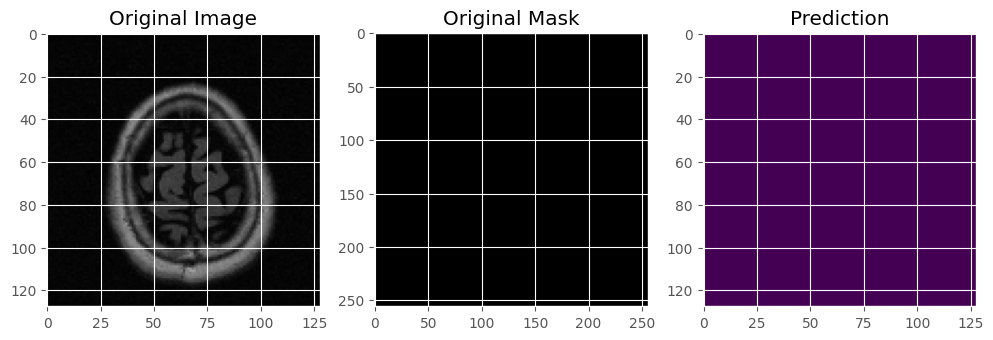

1/1 [==============================] - 0s 23ms/step


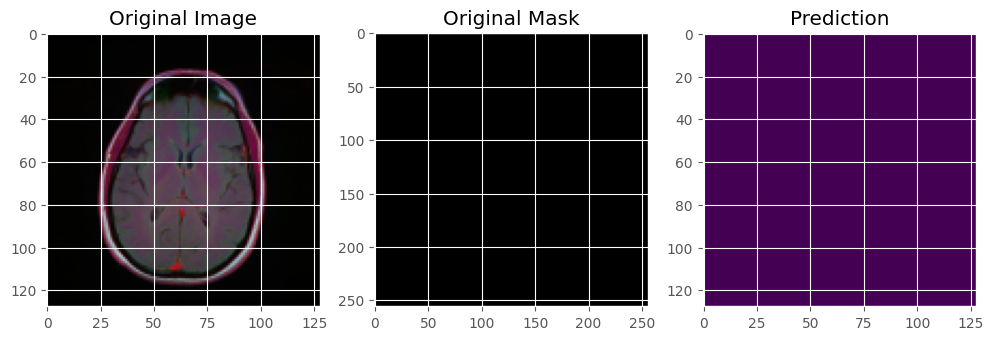

1/1 [==============================] - 0s 22ms/step


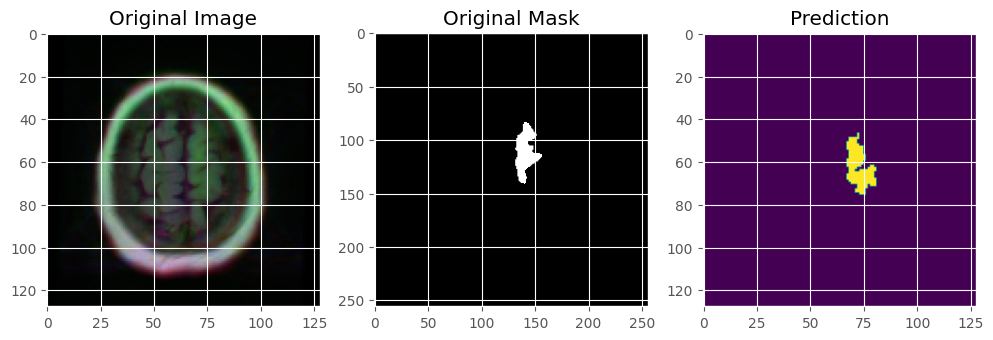

1/1 [==============================] - 0s 25ms/step


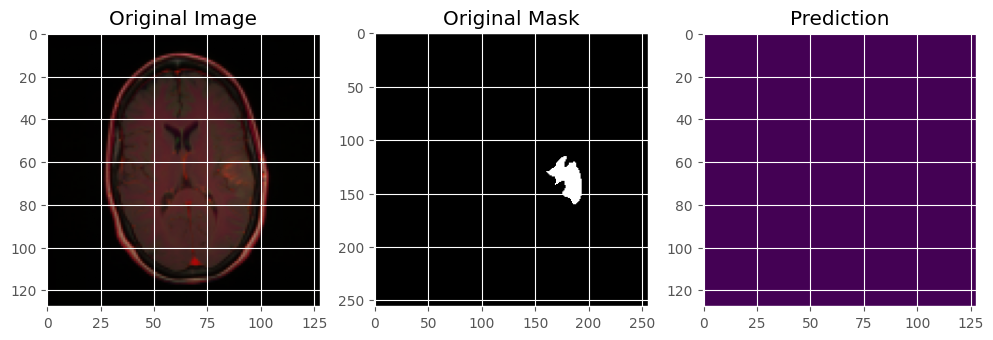

1/1 [==============================] - 0s 21ms/step


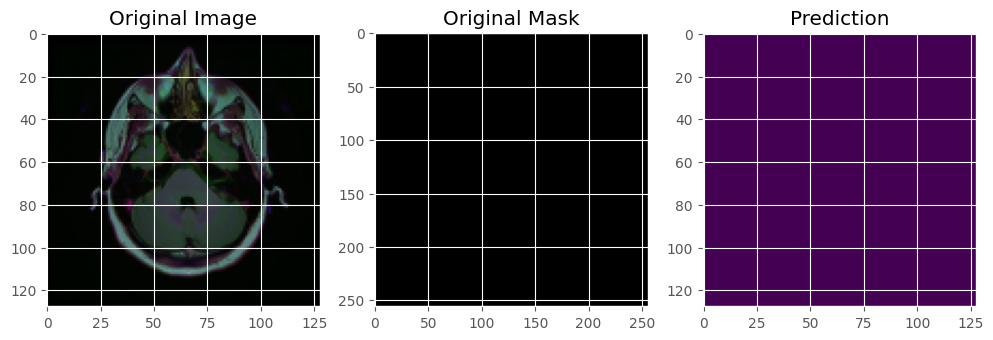

1/1 [==============================] - 0s 21ms/step


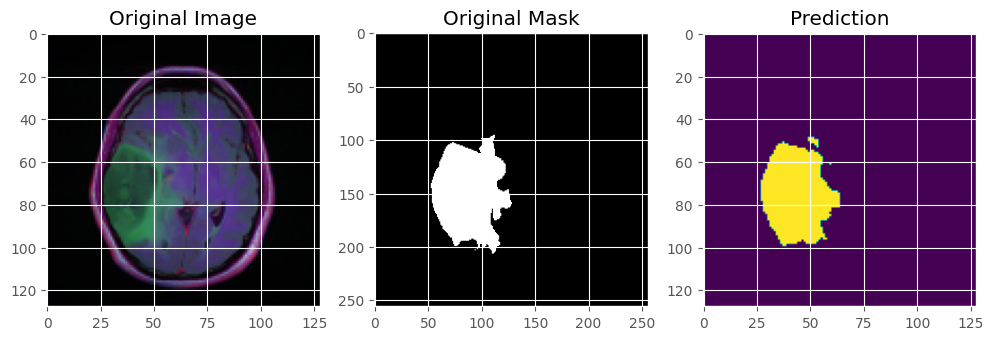

1/1 [==============================] - 0s 24ms/step


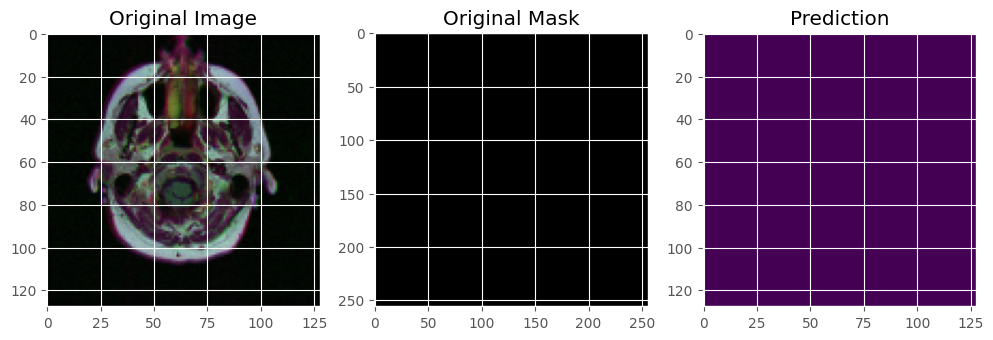

1/1 [==============================] - 0s 22ms/step


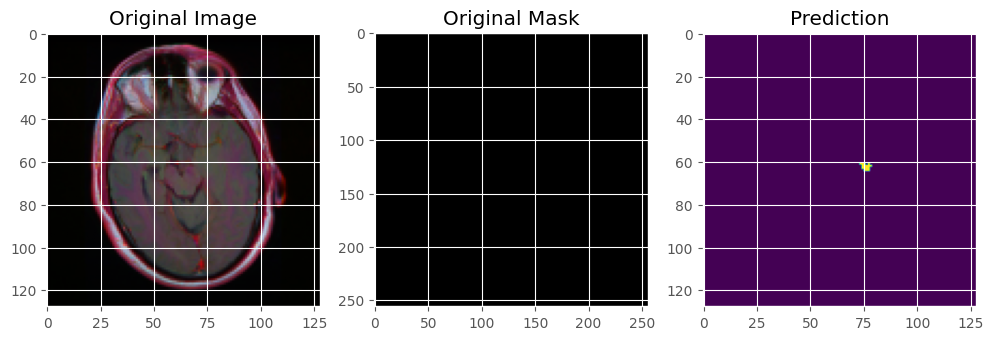

1/1 [==============================] - 0s 23ms/step


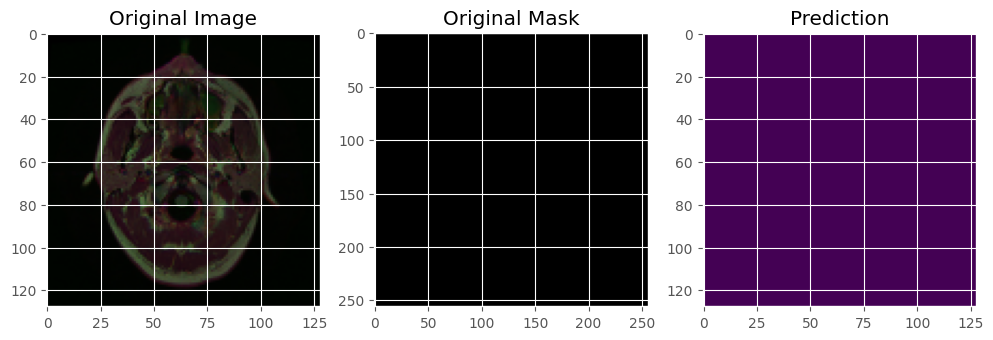

1/1 [==============================] - 0s 20ms/step


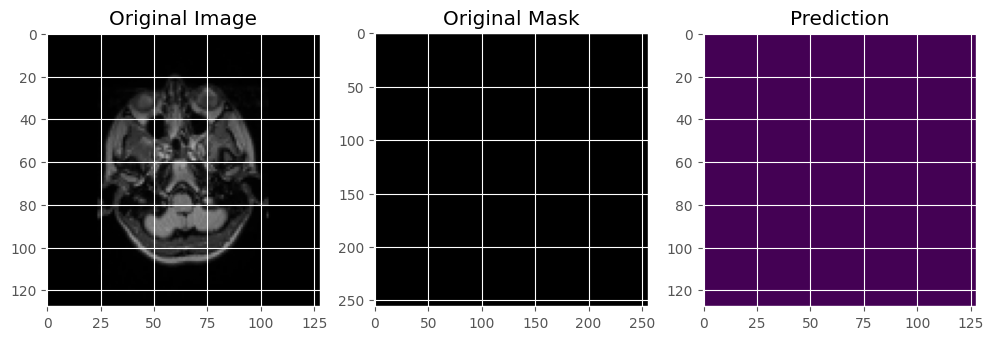

1/1 [==============================] - 0s 28ms/step


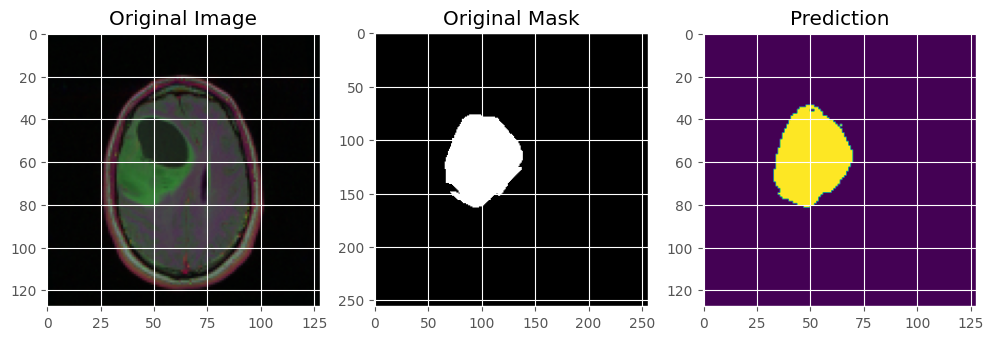

1/1 [==============================] - 0s 20ms/step


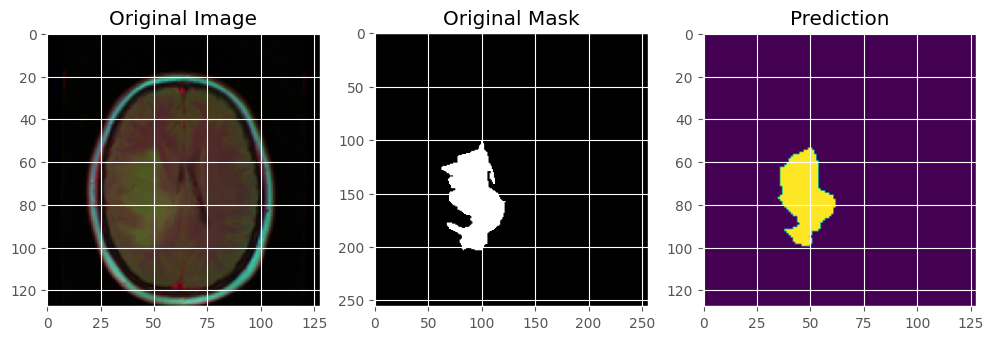

1/1 [==============================] - 0s 23ms/step


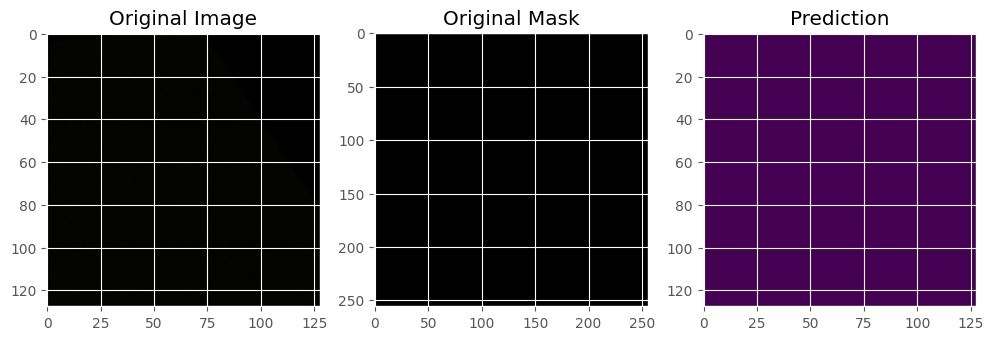

1/1 [==============================] - 0s 20ms/step


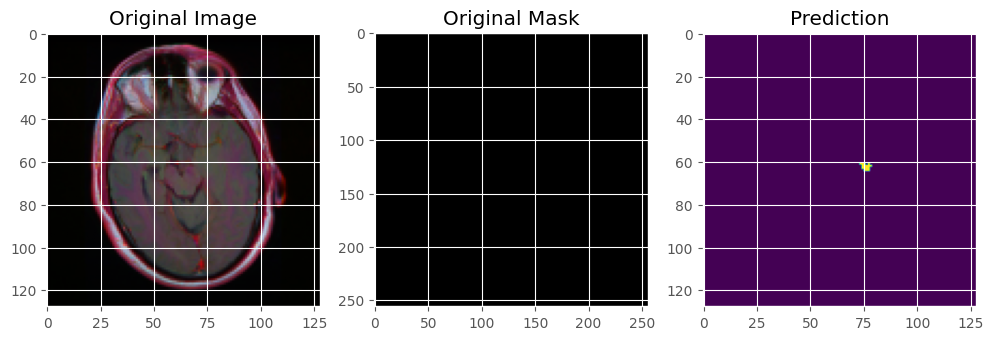

1/1 [==============================] - 0s 36ms/step


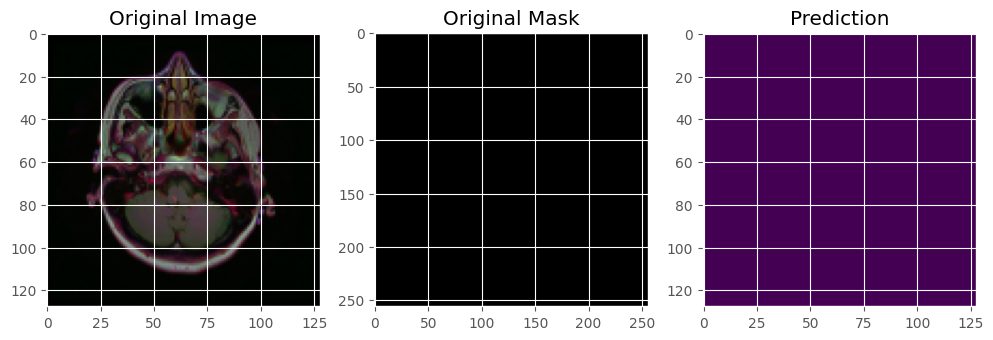

1/1 [==============================] - 0s 42ms/step


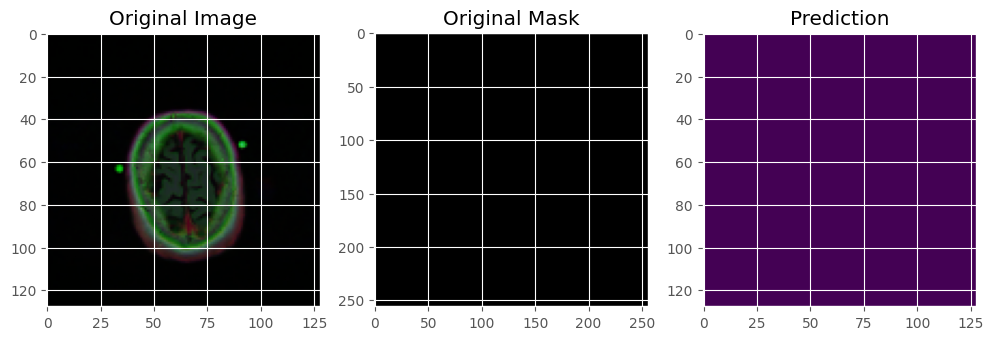

1/1 [==============================] - 0s 29ms/step


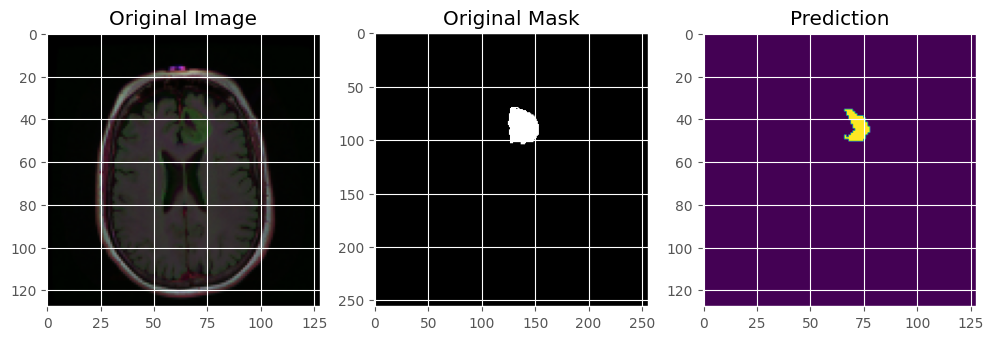

1/1 [==============================] - 0s 46ms/step


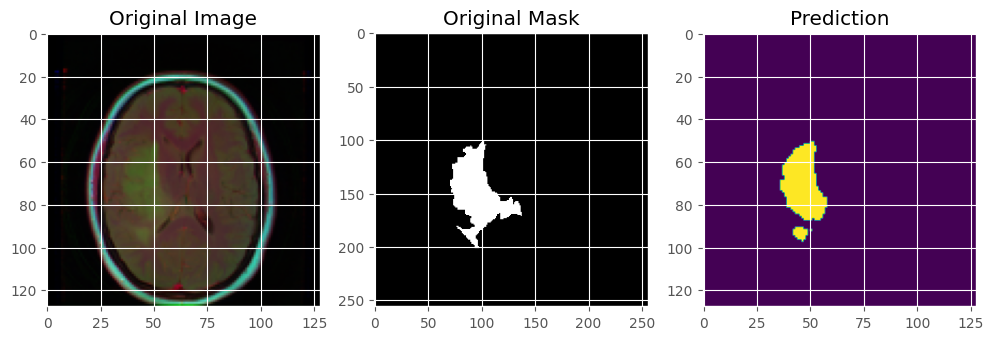

1/1 [==============================] - 0s 28ms/step


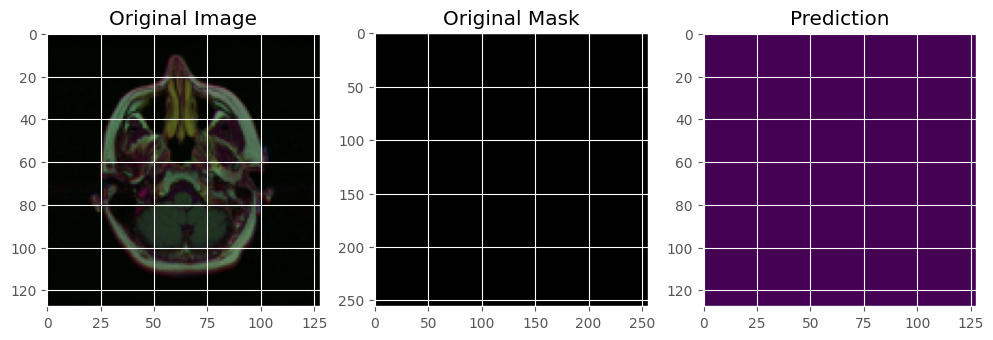

1/1 [==============================] - 0s 26ms/step


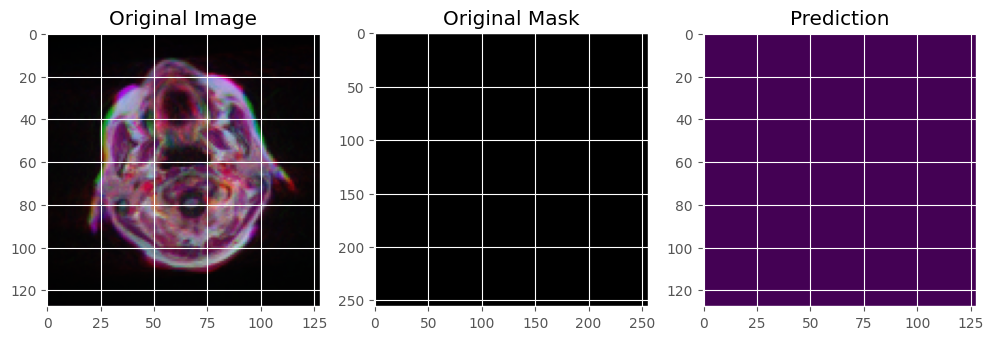

1/1 [==============================] - 0s 24ms/step


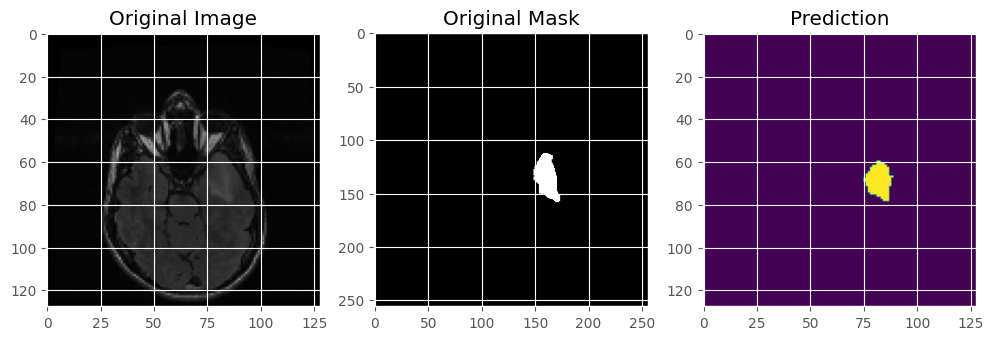

1/1 [==============================] - 0s 22ms/step


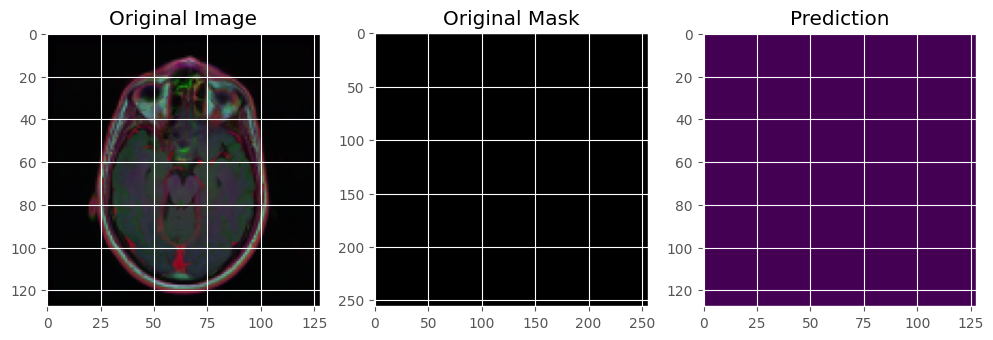

1/1 [==============================] - 0s 26ms/step


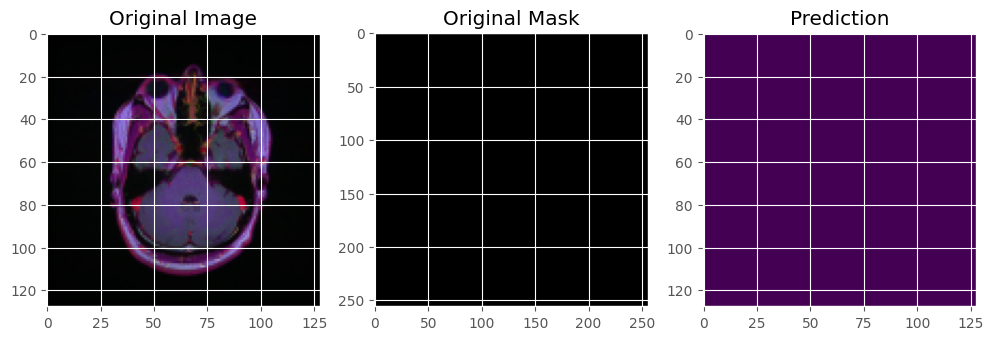

In [19]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

# References

1.   RONNEBERGER, O.; FISCHER, P.; BROX, T. U-Net: Convolutional Networks for Biomedical Image Segmentation. arXiv preprint arXiv:1505.04597, 2015.

2.   Zheng, P., Zhu, X. & Guo, W. Brain tumour segmentation based on an improved U-Net. BMC Med Imaging 22, 199 (2022).